In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
%matplotlib inline

# Setting model and fitting

In [82]:
# def mollow_convol(x, x_0, gamma_0, gamma_1, rabi, I0, I1, bg):
#     result = np.zeros(len(x))
#     i = 0
    
#     for x_cur in x:
#         con_list = np.arange(-50e6,50e6,5e5)
        
#         total = ((1/(1+ (4*((con_list)/gamma_1)**2))) *
#                            (I0*(0.5*gamma_0/((x_cur-x_0+con_list)**2 + (0.5*gamma_0)**2)) +
#                             I1*3*(0.375*gamma_0/((x_cur-x_0+rabi+con_list)**2 + (0.75*gamma_0)**2)) + 
#                             I1*3*(0.375*gamma_0/((x_cur-x_0-rabi+con_list)**2 + (0.75*gamma_0)**2))))*0.5e5
#         temp = np.sum(total)
        
#         result[i] = temp
#         i = i+1
#         temp = 0
    
#     return result + bg

def mollow_convol(x, x_0, gamma_0, gamma_1, gamma_l, rabi, I0, I1, bg):
    result = np.zeros(len(x))
    i = 0
    
    s = 2*((rabi/gamma_0)**2)
    rabi_t = np.sqrt((rabi**2)-(0.25*gamma_0)**2)
    
    for x_cur in x:
        con_list = np.arange(-50e6,50e6,5e5)
        
        total = ((1/(1+ (4*((con_list)/gamma_1)**2))) *
                 I0 * (((s/((1+s)**2))*((0.5*gamma_l)/((x_cur-x_0+con_list)**2 + (0.5*gamma_l)**2))) +
                       (I1*((s)*((0.5*gamma_l)/((x_cur-x_0+con_list)**2 + (0.5*gamma_l)**2)))) +
                       ((0.125*s/(1+s))*(gamma_0/((x_cur-x_0+con_list)**2 + (0.5*gamma_0)**2))) +
                       ((0.0625*s/((1+s)**2))*(((1.5*gamma_0*(s-1))+((-1+(5*s))*(0.5*gamma_0/rabi_t)*(x_cur-x_0+rabi_t+con_list)))/((x_cur-x_0+rabi_t+con_list)**2 + (0.75*gamma_0)**2))) +
                       ((0.0625*s/((1+s)**2))*(((1.5*gamma_0*(s-1))+((-1+(5*s))*(-0.5*gamma_0/rabi_t)*(x_cur-x_0-rabi_t+con_list)))/((x_cur-x_0-rabi_t+con_list)**2 + (0.75*gamma_0)**2)))))*0.5e5

        temp = np.sum(total)
        
        result[i] = temp
        i = i+1
        temp = 0
    
    return result + bg

def fit_mollow_convol(freq, power,power_err):
    mod = Model(mollow_convol)
    gmod = mod
    
    #set parameter and make init guess
    p = Parameters()
    p.add('x_0', 134.5e6)
    p.add('gamma_0', 6.2e6)
    p.add('gamma_1', 3.92e6, vary=0)
    p.add('gamma_l', 0.4e6, vary=0)
    p.add('rabi', 50e6)
    p.add('I0', 5)
    p.add('I1', 1.5e-5)
    p.add('bg', 0.0001)
    
    return gmod.fit(power,x=freq,params=p, weights = 1/(power_err))

In [83]:
filename = '455amp'
start = time.time()
data = np.genfromtxt('data_spectrum/'+filename)
freq_data = data[:,0]*1e6
transmission = data[:,1]/np.max(data[:,1])
trans_err = np.sqrt(data[:,2])/(data[:,5]*np.max(data[:,1]))

fit_convol = fit_mollow_convol(freq_data,transmission,trans_err)
end = time.time()
print(end - start)

0.7827746868133545


[[Model]]
    Model(mollow_convol)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 93
    # variables        = 6
    chi-square         = 169.874730
    reduced chi-square = 1.95258310
    Akaike info crit   = 68.0289463
    Bayesian info crit = 83.2245433
[[Variables]]
    x_0:      1.3446e+08 +/- 125284.433 (0.09%) (init = 1.345e+08)
    gamma_0:  7835484.65 +/- 332251.900 (4.24%) (init = 6200000)
    gamma_1:  3920000 (fixed)
    gamma_l:  400000 (fixed)
    rabi:     64118372.2 +/- 239991.526 (0.37%) (init = 5e+07)
    I0:       28.6603047 +/- 0.87023567 (3.04%) (init = 5)
    I1:       1.5865e-04 +/- 5.1659e-05 (32.56%) (init = 1.5e-05)
    bg:       0.00750047 +/- 0.00307719 (41.03%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(I0, bg)        = -0.813
    C(gamma_0, bg)   = -0.629
    C(x_0, I1)       = -0.582
    C(gamma_0, I0)   = 0.462
    C(I0, I1)        = -0.435
    C(gamma_0, rabi) = 0

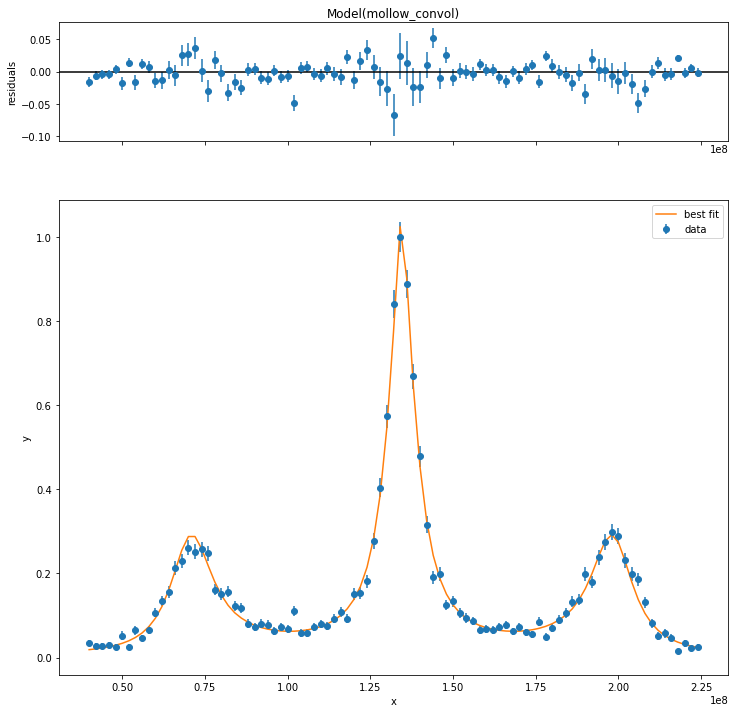

In [84]:
print(fit_convol.fit_report())
plt.rcParams["figure.figsize"] = (12,10)
fit_convol.plot()
plt.show()

# export simulation result

In [79]:
freq_list = np.arange(35,230,0.5)*1e6

result_x_0 = fit_convol.params['x_0'].value
result_gamma_0 = fit_convol.params['gamma_0'].value
result_gamma_1 = fit_convol.params['gamma_1'].value
result_gamma_l = fit_convol.params['gamma_l'].value
result_rabi = fit_convol.params['rabi'].value
result_I0 = fit_convol.params['I0'].value
result_I1 = fit_convol.params['I1'].value
result_bg = fit_convol.params['bg'].value

sim_result = mollow_convol(freq_list, result_x_0, result_gamma_0, result_gamma_1, result_gamma_l, result_rabi, result_I0, result_I1, result_bg)

In [80]:
out_text = np.c_[(freq_list*1e-6, sim_result)]
file_name = 'sim_spectrum/' + filename + '.dat'
np.savetxt(file_name, out_text, delimiter='\t', fmt='%f', header="freq\tnormalize_power")

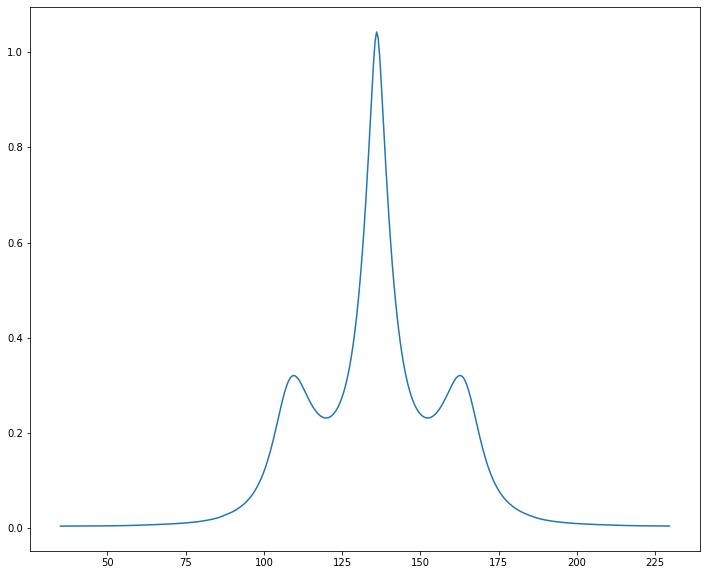

In [81]:
plt.plot(freq_list*1e-6,sim_result)